## Fetch technical functions

In [1]:
# Get the technical functions
! wget https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/calogan_metrics.py
! wget https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/prd_score.py
! wget https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/score.py
! wget https://github.com/TheodorSergeev/mlhep2019_2_phase/raw/master/analysis/embedder.tp
! wget https://github.com/TheodorSergeev/mlhep2019_2_phase/raw/master/analysis/generator.py
! wget https://github.com/TheodorSergeev/mlhep2019_2_phase/raw/master/analysis/discriminator.py

--2019-11-26 13:41:47--  https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/calogan_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4115 (4.0K) [text/plain]
Saving to: ‘calogan_metrics.py.3’

calogan_metrics.py. 100%[===================>]   4.02K  --.-KB/s    in 0s      

2019-11-26 13:41:47 (49.2 MB/s) - ‘calogan_metrics.py.3’ saved [4115/4115]

--2019-11-26 13:41:50--  https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/prd_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available device =", device)

Available device = cuda


## Fetch the dataset

In [3]:
from google.colab import drive
drive.mount('/gdrive')

# Uncomment if running via google colab
def_colab_path = '/gdrive/My Drive/Colab Notebooks/Lambda/CaloGAN/'
train_data_path = def_colab_path + 'data/data_train.npz'
val_data_path   = def_colab_path + 'data/data_val.npz'
test_data_path  = def_colab_path + 'data/data_test.npz'

# Uncomment if running locally
#train_data_path = '../data_train.npz'
#val_data_path   = '../data_val.npz'
#test_data_path  = '../data_test.npz'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Load the data

File `dat_train.npz` contains four arrays: 

  * `EnergyDeposit` - images of calorimeters responses
  * `ParticleMomentum` - $p_x, p_y, p_z$ of initial partice
  * `ParticlePoint` - $x, y$ of initial particle
  * `ParticlePDG` - particle type(either $e^-$ or $\gamma$)

In [26]:
data_train = np.load(train_data_path, allow_pickle=True)
print("Training dataset size =", len(calo_dataset))
print(list(data_train.keys()))

N = 1000 # if require a subset

# [data_size, 900]
# reshaping it as [data_size, channels, img_size_x, img_size_y]
EnergyDeposit    = data_train['EnergyDeposit'][:N].reshape(-1, 1, 30, 30)
ParticleMomentum = data_train['ParticleMomentum'][:N]
ParticlePoint    = data_train['ParticlePoint'][:, :2][:N]
ParticlePDG      = data_train['ParticlePDG'][:N]

EnergyDeposit    = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint    = torch.tensor(ParticlePoint).float()

# Create PyTorch dataloader
BATCH_SIZE = 128

calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint)
calo_dataloader = utils.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

Training dataset size = 1000
['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']


## Training GAN
###### ...is not a simple matter

It depends on architecture, loss, instance noise, augmentation and even luck(recommend to take a look https://arxiv.org/pdf/1801.04406.pdf)


In this notebook I have prepared some basic parts that you could use for your experiments.

### Three types of losses for GANs

https://medium.com/@jonathan_hui/gan-what-is-wrong-with-the-gan-cost-function-6f594162ce01

There were proposed numerous loss functions to train GANs. In this notebook we have implemented three the most popular choices(but feel free to try other variants!):

### `KL`:


$$\mathcal{L}_g = \log(1 - \mathrm{discriminator}(\mathrm{gen}))$$

$$\mathcal{L}_d = - \log(\mathrm{discriminator}(\mathrm{gen})) - \log(1 - \mathrm{discriminator}(\mathrm{real}))$$


### `REVERSED_KL`

$$\mathcal{L}_g = - \log(\mathrm{discriminator}(\mathrm{gen}))$$

$$\mathcal{L}_d = - \log(\mathrm{discriminator}(\mathrm{gen})) - \log(1 - \mathrm{discriminator}(\mathrm{real}))$$


### `WASSERSTEIN`

$$\mathcal{L}_g = - \mathrm{discriminator}(\mathrm{gen})$$

$$\mathcal{L}_d = \mathrm{discriminator}(\mathrm{gen}) - \mathrm{discriminator}(\mathrm{real})$$

In [0]:
TASKS = ['KL', 'REVERSED_KL', 'WASSERSTEIN']

TASK = 'WASSERSTEIN'


# Additional things for Wasserstein GAN
LIPSITZ_WEIGHTS = False
clamp_lower, clamp_upper = -0.01, 0.01

GRAD_PENALTY = True                  # https://arxiv.org/abs/1704.00028
ZERO_CENTERED_GRAD_PENALTY = False   # https://arxiv.org/abs/1705.09367

# Small hack that can speed-up training and improve generalization
INSTANCE_NOISE = True                # https://arxiv.org/abs/1610.04490

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

In [0]:
class GANLosses(object):
    def __init__(self, task, device):
        self.TASK = task
        self.device = device
    
    def g_loss(self, discrim_output):
        eps = 1e-10
        if self.TASK == 'KL': 
            loss = torch.log(1 - discrim_output + eps).mean()    
        elif self.TASK == 'REVERSED_KL':
            loss = - torch.log(discrim_output + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - discrim_output.mean()
        return loss

    def d_loss(self, discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK in ['KL', 'REVERSED_KL']: 
            loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
        return loss

    def calc_gradient_penalty(self, discriminator, data_gen, inputs_batch, inp_data, lambda_reg = .1):
        alpha = torch.rand(inp_data.shape[0], 1).to(self.device)
        dims_to_add = len(inp_data.size()) - 2
        for i in range(dims_to_add):
            alpha = alpha.unsqueeze(-1)
        # alpha = alpha.expand(inp_data.size())

        interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(self.device)

        interpolates.requires_grad = True

        disc_interpolates = discriminator(interpolates, inputs_batch)

        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg
        return gradient_penalty
    
    def calc_zero_centered_GP(self, discriminator, data_gen, inputs_batch, inp_data, gamma_reg = .1):
        
        local_input = inp_data.clone().detach().requires_grad_(True)
        disc_interpolates = discriminator(local_input, inputs_batch)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=local_input,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        return gamma_reg / 2 * (gradients.norm(2, dim=1) ** 2).mean() 

## Defining generator and discriminator

In [0]:
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(p=0.3)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 32, 3)
        
        # size
        self.fc1 = nn.Linear(2592 + 5, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        EnergyDeposit = self.dropout(F.leaky_relu(self.bn1(self.conv1(EnergyDeposit))))
        EnergyDeposit = self.dropout(F.leaky_relu(self.bn2(self.conv2(EnergyDeposit))))
        EnergyDeposit = F.leaky_relu(self.conv3(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv4(EnergyDeposit)) # 32, 9, 9
        EnergyDeposit = EnergyDeposit.view(len(EnergyDeposit), -1)
        
        t = torch.cat([EnergyDeposit, ParticleMomentum_ParticlePoint], dim=1)
        
        t = F.leaky_relu(self.fc1(t))
        t = F.leaky_relu(self.fc2(t))
        t = F.leaky_relu(self.fc3(t))
        if TASK == 'WASSERSTEIN':
            return self.fc4(t)
        else:
            return torch.sigmoid(self.fc4(t))

In [0]:
#from generator import ModelGConvTranspose, NOISE_DIM
#from discriminator import ModelD

class ModelGConvTranspose(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        self.fc1 = nn.Linear(self.z_dim + 2 + 3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 20736)

        self.conv1 = nn.ConvTranspose2d(256, 256, 3, stride=2, output_padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.ConvTranspose2d(256, 128, 3)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.ConvTranspose2d(128, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64, 32, 3)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.ConvTranspose2d(32, 16, 3)
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.ConvTranspose2d(16, 1, 3)
        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        x = torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        
        EnergyDeposit = x.view(-1, 256, 9, 9)
        
        #print(EnergyDeposit.shape)
        EnergyDeposit = F.leaky_relu(self.bn1(self.conv1(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn2(self.conv2(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn3(self.conv3(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn4(self.conv4(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn5(self.conv5(EnergyDeposit)))
        EnergyDeposit = self.conv6(EnergyDeposit)

        return EnergyDeposit

## Check our models on one batch 

In [0]:
discriminator = ModelD().to(device)
generator = ModelGConvTranspose(z_dim=NOISE_DIM).to(device)

In [0]:
EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                       ParticleMomentum_b.to(device), \
                                                       ParticlePoint_b.to(device)
ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)

In [206]:
EnergyDeposit_b.shape

torch.Size([128, 1, 30, 30])

In [207]:
ParticleMomentum_ParticlePoint_b.shape

torch.Size([128, 5])

In [208]:
discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).shape

torch.Size([128, 1])

In [209]:
noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
generator(noise, ParticleMomentum_ParticlePoint_b).shape

torch.Size([128, 1, 30, 30])

In [210]:
print(noise[0])
print(ParticleMomentum_ParticlePoint_b[0])

torch.cat([noise, ParticleMomentum_ParticlePoint_b], dim=1)[0]

tensor([ 1.6308,  0.9788,  0.1980, -0.9203, -0.6347,  0.5647,  1.2597,  0.5279,
         0.3943, -1.8854], device='cuda:0')
tensor([-2.1746, -0.3289, 20.9076,  0.6021,  0.8047], device='cuda:0')


tensor([ 1.6308,  0.9788,  0.1980, -0.9203, -0.6347,  0.5647,  1.2597,  0.5279,
         0.3943, -1.8854, -2.1746, -0.3289, 20.9076,  0.6021,  0.8047],
       device='cuda:0')

## Defining optimiser

In [0]:
learning_rate_dis = 1e-3
learning_rate_gen = 1e-3

g_optimizer = optim.Adam(generator.parameters(),    lr=learning_rate_gen, weight_decay=1e-6)
d_optimizer = optim.SGD(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)
#d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)

## Load scores

In [0]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

def run_training(epochs):

    # ===========================
    # IMPORTANT PARAMETER:
    # Number of D updates per G update
    # ===========================
    k_d, k_g = 5, 1

    gan_losses = GANLosses(TASK, device)
    dis_epoch_loss,  gen_epoch_loss  = [], []
    predictions_dis, predictions_gen = [], []
    prd_auc = []  

    for epoch in tqdm(range(epochs)):
        first = True
        
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                                   ParticleMomentum_b.to(device), \
                                                                   ParticlePoint_b.to(device)
            ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)
            if first:
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
                predictions_dis.append(
                    list(discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy().ravel())
                )

                predictions_gen.append(
                    list(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy().ravel())
                )
            # Optimize D
            for _ in range(k_d):
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
    
                if INSTANCE_NOISE:
                    EnergyDeposit_b = add_instance_noise(EnergyDeposit_b)
                    EnergyDeposit_gen = add_instance_noise(EnergyDeposit_gen)
                    
                loss = gan_losses.d_loss(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b),
                                         discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b))
                if GRAD_PENALTY:
                    grad_penalty = gan_losses.calc_gradient_penalty(discriminator,
                                                                    EnergyDeposit_gen.data,
                                                                    ParticleMomentum_ParticlePoint_b,
                                                                    EnergyDeposit_b.data)
                    loss += grad_penalty
                    
                elif ZERO_CENTERED_GRAD_PENALTY:
                    grad_penalty = gan_losses.calc_zero_centered_GP(discriminator,
                                                                    EnergyDeposit_gen.data,
                                                                    ParticleMomentum_ParticlePoint_b,
                                                                    EnergyDeposit_b.data)
                    loss -= grad_penalty

                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
                if LIPSITZ_WEIGHTS:                    
                    [p.data.clamp_(clamp_lower, clamp_upper) for p in discriminator.parameters()]

            dis_epoch_loss.append(loss.item())

            # Optimize G
            for _ in range(k_g):
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
                
                if INSTANCE_NOISE:
                    EnergyDeposit_b = add_instance_noise(EnergyDeposit_b)
                    EnergyDeposit_gen = add_instance_noise(EnergyDeposit_gen)
                
                loss = gan_losses.g_loss(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
                
            gen_epoch_loss.append(loss.item())
            if first:
                precision, recall = compute_prd_from_embedding(
                    EnergyDeposit_gen.detach().cpu().numpy().reshape(BATCH_SIZE, -1), 
                    EnergyDeposit_b.detach().cpu().numpy().reshape(BATCH_SIZE, -1),
                    num_clusters=30,
                    num_runs=100)
                prd_auc.append(auc(precision, recall))
                first = False
        
        clear_output()
        plt.figure(figsize=(6, 6))
        plt.plot(dis_epoch_loss, label='dis_epoch_loss')
        plt.plot(gen_epoch_loss, label='gen_epoch_loss')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(6, 6))
        plt.hist(predictions_dis[-1], bins=100, label='dis_epoch_loss')
        plt.hist(predictions_gen[-1], bins=100, label='gen_epoch_loss')
        plt.legend()
        plt.show()
        print(np.mean(predictions_dis[-1]), np.mean(predictions_gen[-1]))
        
        plt.figure(figsize=(6, 6))
        plt.plot(prd_auc, label='prd_auc')
        plt.plot()
        plt.legend()
        plt.show()

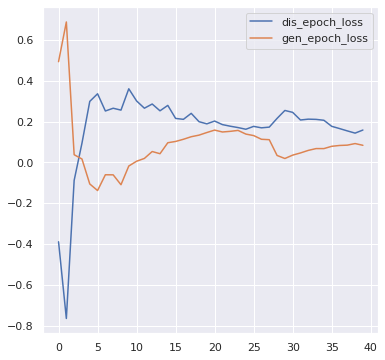

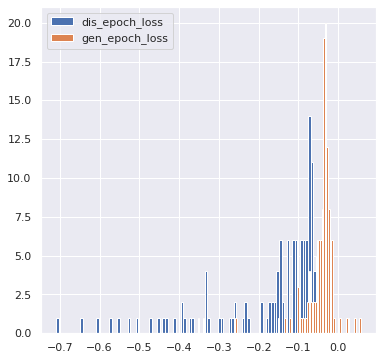

-0.17304337 -0.046521805


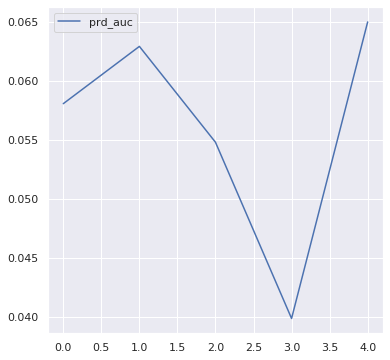



100%|██████████| 5/5 [05:10<00:00, 61.98s/it]



In [216]:
run_training(5)

#### Transfer generator on CPU:

In [218]:
generator_cpu = ModelGConvTranspose(z_dim=NOISE_DIM)
generator_cpu.load_state_dict(generator.state_dict())
generator_cpu.eval()

# Save the trained model on google disk
torch.save(generator_cpu.state_dict(), def_colab_path + 'gan.pt')
print('The model is saved to', def_colab_path + 'gan.pt')

The model is saved to /gdrive/My Drive/Colab Notebooks/Lambda/CaloGAN/gan.pt


## Making predictions

In [0]:
def model_prediction(input_file, output_file, generator_cpu, batch_size=1024, shuffle=False):
    """
    Model test/validation

        Parameters
        ----------
            input_file : str
                Input file name with path (e.g. data/data_val.npz).
            
            output_file : str
                Output file name with path (e.g. output/data_val_prediction.npz).
            
            generator_cpu :

            
            batch_size : int, optional
                Number of elements in a dataloader batch.
            
            shuffle : bool, optional
                If to enable shuffling in batches.

        Returns:
        ----------
            None
    """
    
    dataset = np.load(input_file, allow_pickle=True)
    val_data_path_out = output_file

    part_mom_val   = torch.tensor(dataset['ParticleMomentum']).float()
    part_point_val = torch.tensor(dataset['ParticlePoint'][:, :2]).float()
    part_mom_point = torch.cat([part_mom_val, part_point_val], dim=1)
    
    calo_dataset    = utils.TensorDataset(part_mom_point)
    calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=batch_size, shuffle=shuffle)

    with torch.no_grad():
        EnergyDeposit_val = []

        for part_mom_point_batch in tqdm(calo_dataloader):
            noise = torch.randn(len(part_mom_point_batch[0]), NOISE_DIM)
            EnergyDeposit_val_batch = generator_cpu(noise, part_mom_point_batch[0]).detach().numpy()
            EnergyDeposit_val.append(EnergyDeposit_val_batch)
        
        np.savez_compressed(output_file, 
                            EnergyDeposit=np.concatenate(EnergyDeposit_val, axis=0).reshape(-1, 30, 30))

        del EnergyDeposit_val
    del dataset; del part_mom_val; del part_point_val; del part_mom_point;
    del calo_dataset; calo_dataloader
    return

In [0]:
# (the results are saved to gdrive)

# Validation
model_prediction(def_colab_path + 'data/data_val.npz' , 
                 def_colab_path + 'output/data_val_prediction.npz', 
                 generator_cpu)
# Test
model_prediction(def_colab_path + 'data/data_test.npz', 
                 def_colab_path + 'output/data_test_prediction.npz', 
                 generator_cpu)

# !zip solution.zip data_val_prediction.npz data_test_prediction.npz
# from IPython.display import FileLink
# FileLink('./solution.zip')



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:11<09:01, 11.06s/it]

  4%|▍         | 2/50 [00:22<08:51, 11.06s/it]

  6%|▌         | 3/50 [00:33<08:40, 11.08s/it]

  8%|▊         | 4/50 [00:44<08:28, 11.06s/it]

 10%|█         | 5/50 [00:55<08:18, 11.07s/it]

 12%|█▏        | 6/50 [01:06<08:07, 11.08s/it]

 14%|█▍        | 7/50 [01:17<07:55, 11.06s/it]

 16%|█▌        | 8/50 [01:28<07:44, 11.07s/it]

 18%|█▊        | 9/50 [01:39<07:33, 11.06s/it]

 20%|██        | 10/50 [01:50<07:20, 11.02s/it]

 22%|██▏       | 11/50 [02:01<07:09, 11.01s/it]

 24%|██▍       | 12/50 [02:12<06:59, 11.04s/it]

 26%|██▌       | 13/50 [02:23<06:49, 11.07s/it]

 28%|██▊       | 14/50 [02:34<06:38, 11.08s/it]

 30%|███       | 15/50 [02:45<06:27, 11.07s/it]

 32%|███▏      | 16/50 [02:56<06:15, 11.05s/it]

 34%|███▍      | 17/50 [03:07<06:04, 11.06s/it]

 36%|███▌      | 18/50 [03:19<05:53, 11.05s/it]

 38%|███▊      | 19/50 [03:30<05:42, 11.06s/it]

 40%|████      | 20/50 [03:41<05:31,

# A few words about metrics

### Lets generate some fake data

In [0]:
noise = torch.randn(len(ParticleMomentum), NOISE_DIM)
ParticleMomentum_ParticlePoint = torch.cat([ParticleMomentum, 
                                            ParticlePoint], dim=1)
EnergyDeposit_gen = generator_cpu(noise, ParticleMomentum_ParticlePoint)

In [0]:
EnergyDeposit_gen = EnergyDeposit_gen.detach().cpu().numpy().reshape(-1, 30, 30)
EnergyDeposit = EnergyDeposit.detach().cpu().numpy().reshape(-1, 30, 30)

#### Plot one image

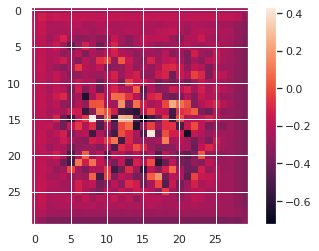

In [0]:
plt.figure()
plt.imshow(EnergyDeposit_gen[0])
plt.colorbar()

## Calculate PRD score between these batch 

In [0]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.batchnorm0 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, 2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 2, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 2, stride=2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 2)
        
        self.dropout = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(256, 256) 
        self.batchnorm4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2 + 3)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc4(x), self.fc5(x)
    
    def get_encoding(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

def load_embedder(path):
    embedder = torch.load(path)
    embedder.eval()
    return embedder

embedder = load_embedder('./embedder.tp')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [0]:
data_real = embedder.get_encoding(torch.tensor(EnergyDeposit).float().view(-1, 1, 30, 30)).detach().numpy()
data_fake = embedder.get_encoding(torch.tensor(EnergyDeposit_gen).float().view(-1, 1, 30, 30)).detach().numpy()

In [0]:
def plot_pr_aucs(precisions, recalls):
    plt.figure(figsize=(12, 12))
    pr_aucs = []
    for i in range(len(recalls)):
        plt.step(recalls[i], precisions[i], color='b', alpha=0.2,  label='PR-AUC={}'.format(auc(precisions[i], recalls[i])))
        pr_aucs.append(auc(precisions[i], recalls[i]))
    plt.step(np.mean(recalls, axis=0), np.mean(precisions, axis=0), color='r', alpha=1,  label='average')
    plt.fill_between(np.mean(recalls, axis=0), 
                     np.mean(precisions, axis=0) - np.std(precisions, axis=0) * 3,
                     np.mean(precisions, axis=0) + np.std(precisions, axis=0) * 3, color='g', alpha=0.2,  label='std')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    print(np.mean(pr_aucs), np.std(pr_aucs))
    plt.legend()
    
    return pr_aucs

def calc_pr_rec(data_real, data_fake, num_clusters=20, num_runs=10, NUM_RUNS=10):
    precisions = []
    recalls = []
    for i in tqdm(range(NUM_RUNS)):
        precision, recall = compute_prd_from_embedding(data_real, data_fake, num_clusters=num_clusters, num_runs=num_runs)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls

In [0]:
precisions, recalls = calc_pr_rec(data_real, data_fake, num_clusters=100, num_runs=20)

100%|██████████| 10/10 [02:48<00:00, 16.84s/it]


4.9707244091382323e-05 2.6298037767461675e-05


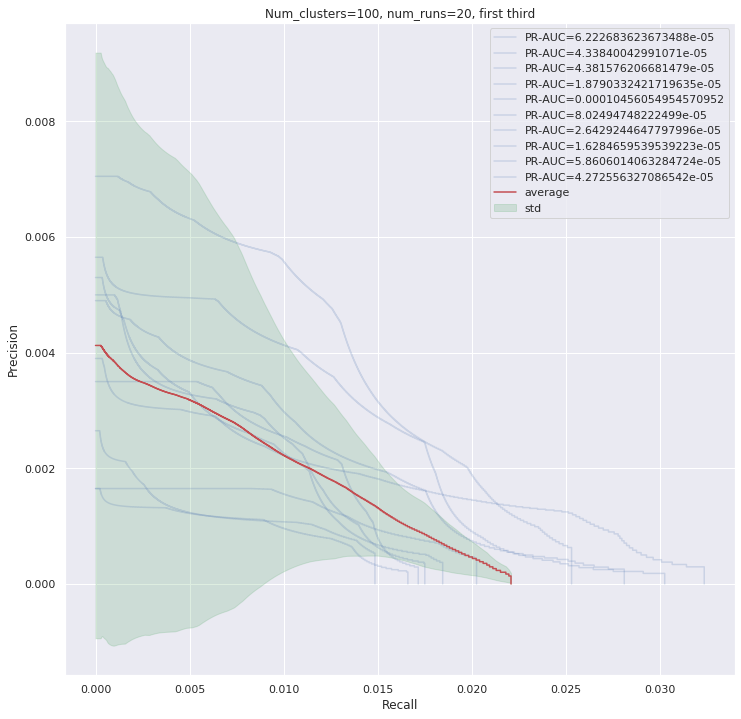

In [0]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [0]:
pr_aucs

[6.222683623673488e-05,
 4.33840042991071e-05,
 4.381576206681479e-05,
 1.8790332421719635e-05,
 0.00010456054954570952,
 8.02494748222499e-05,
 2.6429244647797996e-05,
 1.6284659539539223e-05,
 5.8606014063284724e-05,
 4.272556327086542e-05]

## Physical metrics

In [0]:
import matplotlib.lines as mlines
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

def plot_axes_for_shower(ecal, point, p):
    x = np.linspace(-14.5, 14.5, 30)
    y = np.linspace(-14.5, 14.5, 30)

    xx, yy = np.meshgrid(x, y)
    zoff = 25.
    ipic = 3
    orth = np.array([-p[1], p[0]])

    pref = point[:2] + p[:2] * zoff / p[2]

    p1 = pref - 10 * p[:2]
    p2 = pref + 10 * p[:2]
    p3 = pref - 10 * orth
    p4 = pref + 10 * orth

    plt.contourf(xx, yy, np.log(ecal + 1), cmap=plt.cm.inferno)
    newline(p1, p2)
    newline(p3, p4)
    plt.colorbar()

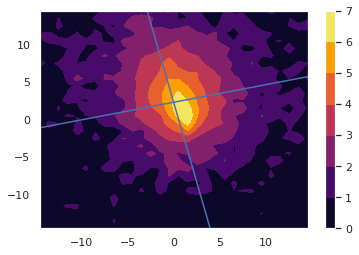

In [0]:
idx = 2
plot_axes_for_shower(EnergyDeposit[idx], point=ParticlePoint[idx].detach().numpy(),
                     p=ParticleMomentum[idx].detach().numpy())

In [0]:
from calogan_metrics import get_assymetry, get_shower_width, get_sparsity_level

In [0]:
assym = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
assym_ortho = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sh_width = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
sh_width_ortho = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sparsity_level = get_sparsity_level(EnergyDeposit)

## Longitudual cluster asymmetry

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


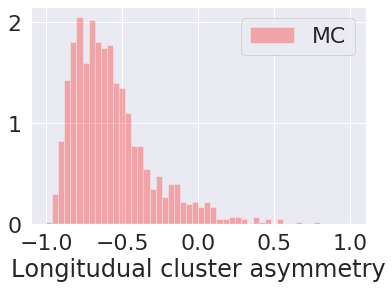

In [0]:
sns.set(font_scale=2)
plt.hist(assym, bins=50, range=[-1, 1], color='red', alpha=0.3, normed=True, label='MC');
plt.xlabel('Longitudual cluster asymmetry')
plt.legend(loc='best')

## Transverse cluster asymmetry

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


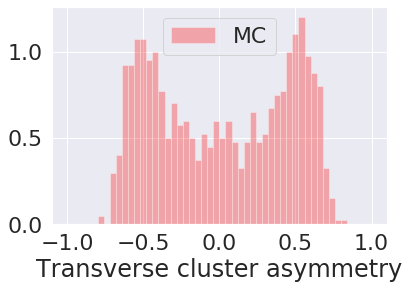

In [0]:
sns.set(font_scale=2)
plt.hist(assym_ortho, bins=50, range=[-1, 1], color='red', alpha=0.3, normed=True, label='MC');
plt.xlabel('Transverse cluster asymmetry')
plt.legend(loc='best')

## Cluster longitudual width

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Arbitrary units')

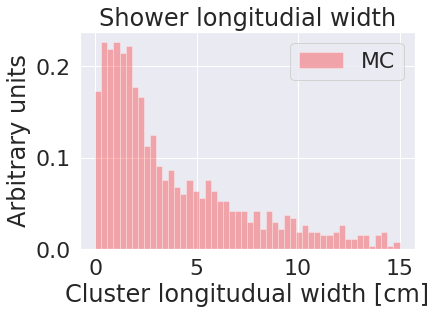

In [0]:
plt.hist(sh_width, bins=50, range=[0, 15], normed=True, alpha=0.3, color='red', label='MC');
plt.title('Shower longitudial width')
plt.legend(loc='best')
plt.xlabel('Cluster longitudual width [cm]')
plt.ylabel('Arbitrary units')

## Cluster trasverse width

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Arbitrary units')

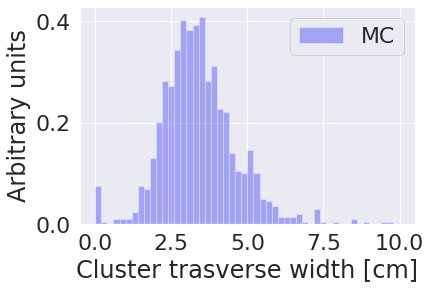

In [0]:
plt.hist(sh_width_ortho, bins=50, range=[0,10], normed=True, alpha=0.3, color='blue', label='MC');
#plt.title('Shower transverse width')
plt.legend(loc='best')
plt.xlabel('Cluster trasverse width [cm]')
plt.ylabel('Arbitrary units')

## Sparsity

In [0]:
alphas = np.log(np.logspace(-5, -1, 20))
means_r = np.mean(sparsity_level, axis=1)
stddev_r = np.std(sparsity_level, axis=1)

Text(0, 0.5, 'Fraction of cells above threshold')

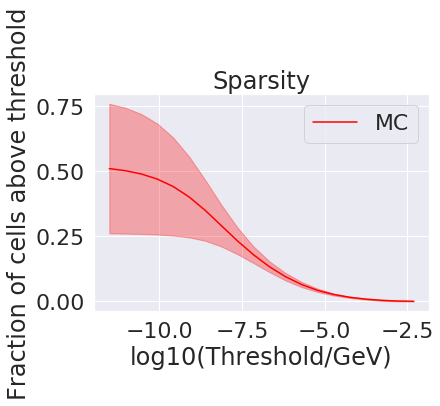

In [0]:
plt.plot(alphas, means_r, color='red')
plt.fill_between(alphas, means_r-stddev_r, means_r+stddev_r, color='red', alpha=0.3)
plt.legend(['MC'])
plt.title('Sparsity')
plt.xlabel('log10(Threshold/GeV)')
plt.ylabel('Fraction of cells above threshold')

In [0]:
from calogan_metrics import get_physical_stats
real_phys_stats = get_physical_stats(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy())
gen_phys_stats = get_physical_stats(EnergyDeposit_gen, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy())

/content/calogan_metrics.py:80: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sum_2 - sum_1 * sum_1)


In [0]:
precisions, recalls = calc_pr_rec(real_phys_stats, gen_phys_stats, num_clusters=100, num_runs=20)

100%|██████████| 10/10 [02:39<00:00, 16.07s/it]


0.002660411819795496 0.000161140961304176


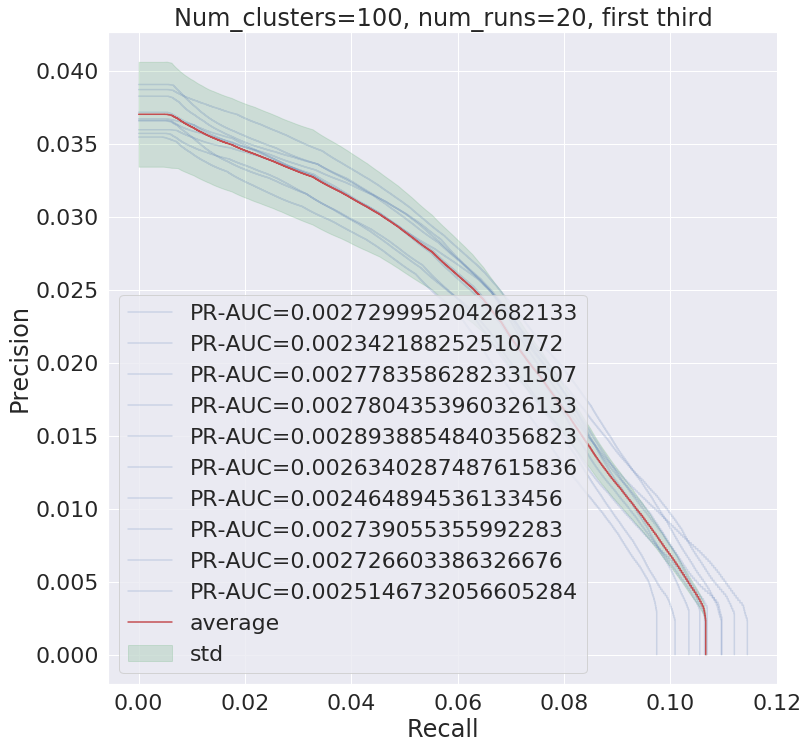

In [0]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [0]:
pr_aucs

[0.0027299952042682133,
 0.002342188252510772,
 0.0027783586282331507,
 0.0027804353960326133,
 0.0028938854840356823,
 0.0026340287487615836,
 0.002464894536133456,
 0.002739055355992283,
 0.002726603386326676,
 0.0025146732056605284]